# 2D Convolution Example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import os
from PIL import Image

from tensorboard.plugins import projector

from kernel_viz import put_kernels_on_grid
import toys

%matplotlib inline
from IPython.core.pylabtools import figsize

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.__version__

'1.8.0'

## Load the dataset

Let's do something *not* MNIST for a change.

The recommended way of getting images into TensorFlow is to create a TFrecord file- they're not the easiest format to work with though. With the new `tf.data` API, though, it's pretty easy to create a flexible input pipeline to pull images from disk.

We want our input pipeline to:

* load images and labels into a queue
* shuffle them
* parse the image data
* maybe do some augmentation
* put them into batches
* **prefetch the batches**

### Write a function that loads images and converts to common range and size

In [3]:
def parse_function(filename, label, size=100):
    # load the file and interpret the raw data as a JPG
    image_string = tf.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    # convert to float values between 0 and 1
    image = tf.image.convert_image_dtype(image, tf.float32)
    # resize and return
    resized = tf.image.resize_images(image, [size,size])
    return resized, label

### Add some random noise

In [4]:
def augment(im, label):
    im = tf.image.random_flip_left_right(im)
    im = tf.image.random_brightness(im, max_delta=0.35)
    im = tf.image.random_saturation(im, lower=0.75, upper=1.25)
    im = tf.clip_by_value(im, 0.0, 1.0)
    return im, label

### Build lists of all the locations of all the images (train and test sets, plus labels)

In [5]:
train0 = "images/0/"
train1 = "images/1/"
test0 = "images/test/0/"
test1 = "images/test/1/"

trainfiles = [train0+x for x in os.listdir(train0)] + [train1+x for x in os.listdir(train1)]
trainlabels = [0]*len(os.listdir(train0)) + [1]*len(os.listdir(train1))

testfiles = [test0+x for x in os.listdir(test0)] + [test1+x for x in os.listdir(test1)]
testlabels = [0]*len(os.listdir(test0)) + [1]*len(os.listdir(test1))

### Use `tf.data.Dataset` to build input pipelines

One for training, one for testing.

In [6]:
def training_input_dataset(epochs=10):
    ds = tf.data.Dataset.from_tensor_slices((trainfiles, trainlabels))
    ds = ds.repeat(epochs)
    ds = ds.shuffle(epochs*len(trainfiles))
    ds = ds.map(parse_function)
    ds = ds.map(augment, num_parallel_calls=4)
    ds = ds.batch(25)
    ds = ds.prefetch(1)
    return ds

In [7]:
def test_input_dataset(epochs=1):
    ds = tf.data.Dataset.from_tensor_slices((testfiles, testlabels))
    #ds = ds.repeat(epochs)
    ds = ds.map(parse_function)
    ds = ds.batch(len(testfiles))
    ds = ds.prefetch(1)
    return ds

In [8]:
x, y = training_input_dataset().make_one_shot_iterator().get_next()

In [9]:
x

<tf.Tensor 'IteratorGetNext:0' shape=(?, 100, 100, 3) dtype=float32>

In [10]:
y

<tf.Tensor 'IteratorGetNext:1' shape=(?,) dtype=int32>

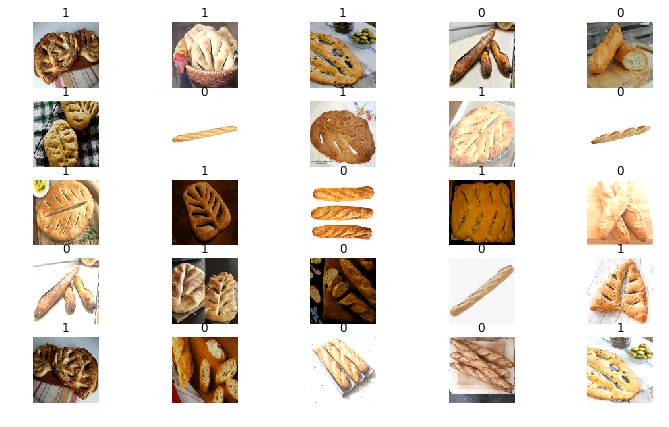

In [11]:
figsize(12, 7)
with tf.Session() as sess:
    im, lab = sess.run([x,y])
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(im[i,:,:,:])
        plt.title(lab[i])
        plt.axis("off")

## Save some metadata for embedding your test set

Let's record some metadata so we can tell what's happening in the embedding projector.

If you have a *lot* of test data points, you may need to add a smaller `tf.data.Dataset` object for the embeddings.

In [16]:
toys.prepare_embedding_metadata(test_input_dataset(), "logs/", 50)

# BUILD THE GRAPH

In [18]:
tf.reset_default_graph()


epochs=1000
training = tf.placeholder_with_default(True, None, name="training_ph")

train_ds = training_input_dataset()
test_ds = test_input_dataset()
data_iterator = tf.data.Iterator.from_structure(train_ds.output_types, 
                                               train_ds.output_shapes)
img, y_ = data_iterator.get_next()
training_init_op = data_iterator.make_initializer(train_ds)
test_init_op = data_iterator.make_initializer(test_ds)

y_oh = tf.one_hot(y_, 2)

print("img:", img.get_shape())

net = tf.layers.conv2d(img, 48, [7, 7], strides=5, padding="same", activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2, padding="same")
print("pool1:", net.get_shape())

viz = put_kernels_on_grid([x for x in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
             if "kernel" in x.name][0])
tf.summary.image("conv0_kernels", viz)
print("viz:", viz.get_shape())

for i, k in enumerate([16]):
    net = tf.layers.conv2d(net, k, [3, 3], padding="same", activation=tf.nn.relu)
    net = tf.layers.max_pooling2d(net, pool_size=2, strides=2, padding="same")
    print("pool %s"%(i+1), net.get_shape())


flat = tf.layers.flatten(net, name="flat")
print("flat:", flat.get_shape())

dropout = tf.layers.dropout(flat, rate=0.5, training=training)
logits = tf.layers.dense(dropout, 2)
probs = tf.nn.softmax(logits)
predictions = tf.argmax(logits, 1, output_type=tf.int32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, y_), tf.float32))

loss = tf.losses.softmax_cross_entropy(y_oh, logits)
global_step = tf.train.get_or_create_global_step()
learn_rate = tf.train.exponential_decay(1e-3, global_step=global_step, 
                                        decay_steps=500, decay_rate=0.5)
optimizer = tf.train.RMSPropOptimizer(learn_rate)
train_op = optimizer.minimize(loss, global_step=global_step)


lr_summary = tf.summary.scalar("learning_rate", learn_rate)
acc_summary = tf.summary.scalar("accuracy", accuracy)
loss_summary = tf.summary.scalar("loss", loss)
toys.add_conv_histograms()
merged = tf.summary.merge_all()

img: (?, 100, 100, 3)
pool1: (?, 10, 10, 48)
grid: 48 = (6, 8)
viz: (1, 54, 72, 3)
pool 1 (?, 5, 5, 16)
flat: (?, 400)


In [20]:
embed_op, config = toys.generate_embedding_op(flat, len(testfiles))

In [22]:
saver = tf.train.Saver()
with tf.Session() as sess:
    # object to save training summaries
    train_writer = tf.summary.FileWriter('logs/',
                                      sess.graph)
    # object for saving test summaries
    test_writer = tf.summary.FileWriter("logs/test/", flush_secs=5)
    # record visualization metadata
    projector.visualize_embeddings(train_writer, config)
    sess.run(tf.global_variables_initializer())
    
    
    for e in tqdm(range(501)):
        sess.run(training_init_op)
        #im, lab = mnist.train.next_batch(250)
        _, summ = sess.run([train_op, merged])
        train_writer.add_summary(summ, e)
        if e % 10 == 0:
            sess.run(test_init_op)
            a, l, _ = sess.run([acc_summary, loss_summary, embed_op],
                              feed_dict={training:False})
            test_writer.add_summary(a, e)
            test_writer.add_summary(l, e)
            
            #_ = sess.run(store_embeddings)
            saver.save(sess, "logs/model.ckpt", e)
    


100%|██████████| 501/501 [00:46<00:00, 10.79it/s]
